# Reconstruction of volume from simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, initialize_ab_initio_vol
import jax
from jax import random

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2

plt.rcParams["figure.figsize"]=8,8

### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

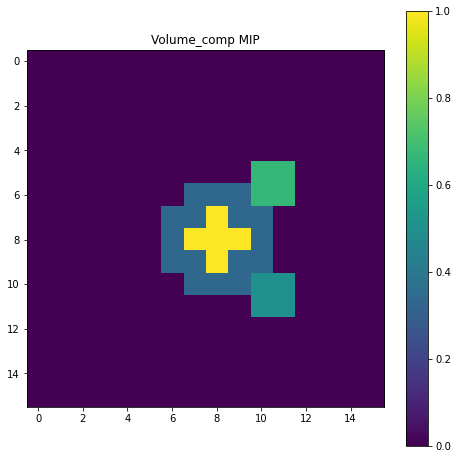

In [3]:
nx = 16
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])
pixel_size = dimensions[0]/shape[0]

# A volume with components
centres = np.array([[0,0,0], [3, 3, 0], [3, -3, 0], [0,0,3]])
radii = np.array([3, 1.5, 1.5, 1.5])
intensities = np.array([10,15,20, 20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid, _ = volume_fourier(vol, pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

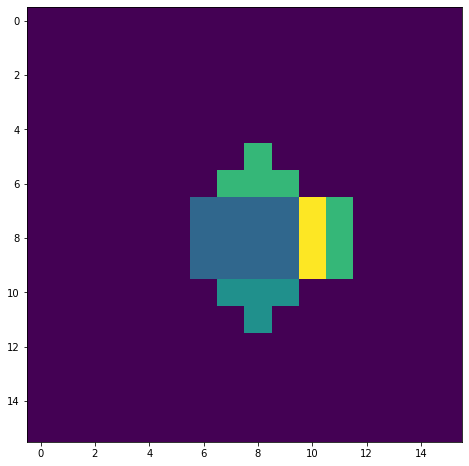

In [4]:
mip_y(vol)

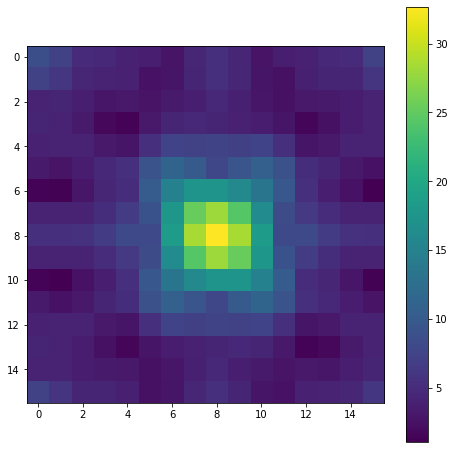

In [5]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

### Generate the data

CTF

In [6]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
_, p = next(dfiter)

#ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE], 
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC], 
#              'cs'    : p[star.Relion.CS], 
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array([p[star.Relion.DEFOCUSU],
                      p[star.Relion.DEFOCUSV],
                      p[star.Relion.DEFOCUSANGLE], 
                      p[star.Relion.PHASESHIFT],
                      p[star.Relion.VOLTAGE],
                      p[star.Relion.AC],
                      p[star.Relion.CS],
                      0,
                      2 * pixel_size])

/Users/bogdan/Work/simple_cryoem/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/Users/bogdan/Work/simple_cryoem/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


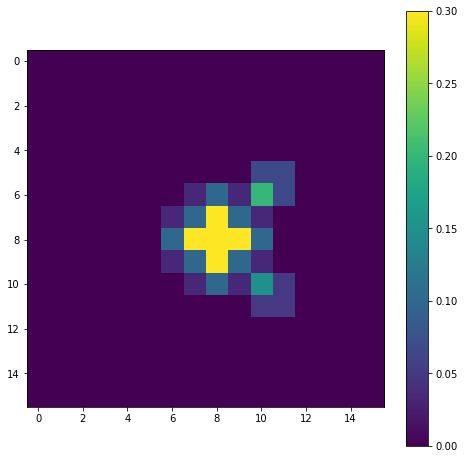

In [7]:
radius = 0.8
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "nn")
s = 17
img = slice_func(0.1*vol_fourier, [0,0,0], [0,0], None)
img_r = jnp.fft.fftshift(jnp.real(jnp.fft.ifft2((img.reshape([nx,nx]))))) 
plt.imshow(img_r); plt.colorbar()

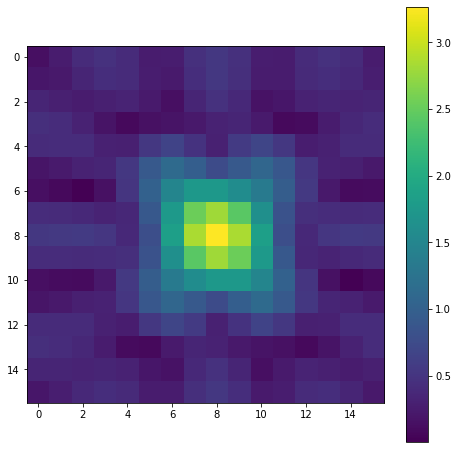

In [8]:
img_f0 = jnp.fft.fftshift(img.reshape([nx,nx]))
plt.imshow(jnp.abs(img_f0));plt.colorbar()

Generate projections (in Fourier domain)

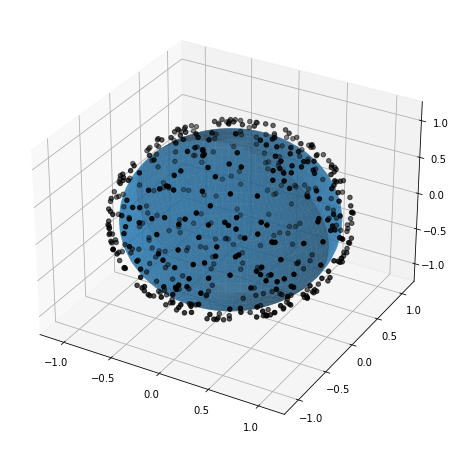

In [11]:
# Orientations
N = 2000

#s = 0.05
s = 0.1
angles_true = generate_uniform_orientations(N)
#jnp.array(np.random.rand(N,3))*jnp.pi*2

#angles_true = jnp.array(np.random.rand(N,3))*jnp.pi/4 + jnp.pi

# Non uniformly distributed orientations (here, two clusters)
#angles_true = s*np.random.randn(int(N),3)
#angles_true = np.concatenate([s*np.random.randn(2250,3), 
#                             s*np.random.randn(2250,3)+np.pi*2/3, 
#                              np.random.rand(500,3)*jnp.pi*2
#                             ], axis=0)
#np.random.shuffle(angles_true)
#angles_true = jnp.array(angles_true)

#angles_true = np.zeros([N,3])
#angles_true[:,1] = s*np.random.randn(N) - np.pi/2
#angles_true = jnp.array(angles_true)

plot_angles(angles_true[:500])

1.1440691947937012
0.7455705165980094


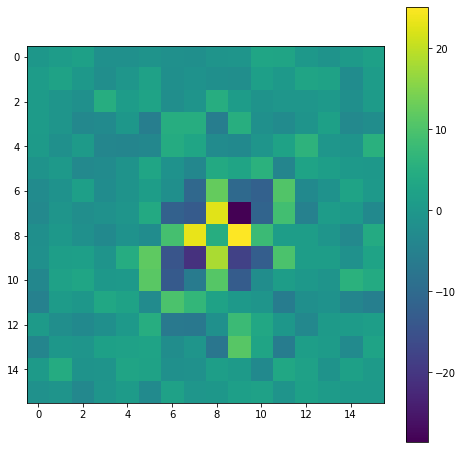

In [12]:
radius = 0.8
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "nn")

img0 = slice_func(vol_fourier, [0,0,0], [0,0], ctf_params0)


shifts_true = jnp.zeros([N,3])
ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true, shifts_true, ctf_params)

norm0 = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

# Noise
imgs += (np.random.randn(N, nx*nx) + 1j*np.random.randn(N, nx*nx)) * jnp.max(img0) *0.1

norm1 = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

print(time.time()-start)

#SNR
print(norm0/norm1)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

### Crop images and volume:

In [13]:
old_nx = jnp.sqrt(imgs.shape[1]).astype(jnp.int64)
nx = 16

if old_nx > 16:
    imgs = imgs.reshape(imgs.shape[0], old_nx, old_nx)
    imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
    imgs = imgs.reshape(imgs.shape[0], nx*nx)
    #imgs2 = imgs2.reshape(imgs2.shape[0], nx*nx)

    vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

    y_grid = x_grid
    z_grid = x_grid

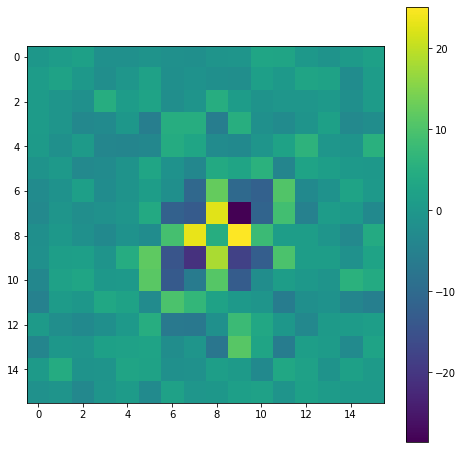

In [14]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

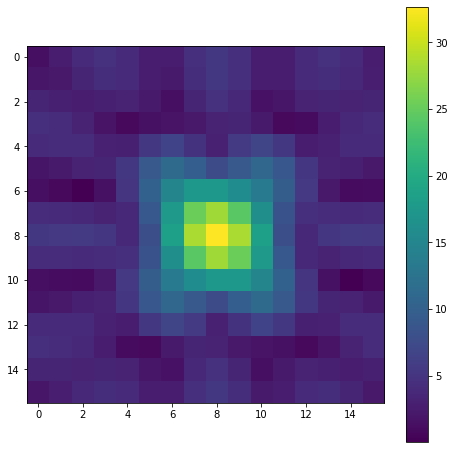

In [15]:
#mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.abs((vol_fourier[:,:,0])))); plt.colorbar()

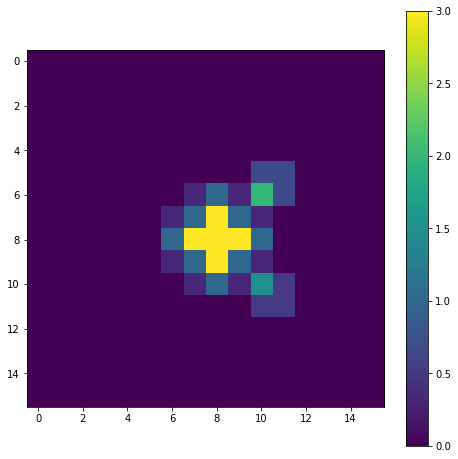

In [16]:
#mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier[:,:,0])))); plt.colorbar()

### Loss functions for the new dimension

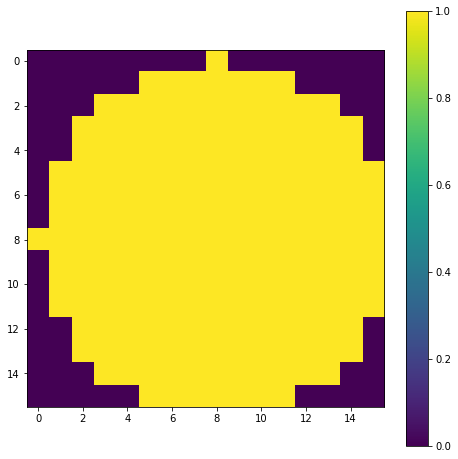

In [18]:
alpha = 0.01
#alpha = 1/N

radius = 0.4 # for nx=16
#radius = 0.8 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [19]:
sigma_noise = jnp.ones(nx*nx)

In [23]:
start = time.time()
ll = loss_func_batched(vol_fourier, angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20], sigma_noise)
#ll = loss_func_batched(np.random.randn(nx,nx,nx), angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
print(time.time()-start)
print(ll.shape)

0.0028769969940185547
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [24]:
start = time.time()
ll = grad_loss_volume(np.random.randn(nx,nx,nx), angles_true[0],  shifts_true[0], ctf_params[0], imgs[0], sigma_noise)
print(time.time()-start)
print(ll.shape)

0.0027589797973632812
(16, 16, 16)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [25]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(np.random.randn(nx,nx,nx), angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx], sigma_noise)
print(time.time()-start)
print(ll.shape)

0.0057659149169921875
(16, 16, 16)


### MCMC - vol

In [75]:
def plot_true_vs_estimated(vol_true, vol_estimated):

    plt.rcParams["figure.figsize"]=16,16
    plt.subplot(2,2,1)
    plt.imshow(jnp.abs(jnp.fft.fftshift(vol_true[:,:,0]))); plt.colorbar()
    plt.title('True')
    plt.subplot(2,2,2)
    plt.imshow(jnp.abs(jnp.fft.fftshift(vol_estimated[:,:,0]))); plt.colorbar()
    plt.title('Sampled')
    plt.subplot(2,2,3)
    plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_true)))[:,:,16]); 
    plt.colorbar()
    plt.title('True')
    plt.subplot(2,2,4)
    plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_estimated)))[:,:,16]); 
    plt.colorbar()
    plt.title('Estimated')

    plt.rcParams["figure.figsize"]=8,8

In [72]:
#alpha = 1e-10
alpha = 0.01

radius = 0.8 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128)
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

logPi = lambda v : -loss_func_sum(v, angles_true, shifts_true, ctf_params, imgs, 1)
gradLogPi = lambda v : -jnp.conj(grad_loss_volume_batched(v, angles_true, shifts_true, ctf_params, imgs, 1))

In [73]:
N_mc_samples = 100
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx)) 

proposal_params_mala = {"tau" : 0.005}
proposal_params_hmc = {"dt" : 0.5, "L" : 10}

v_hmc_mean, r_hmc, v_hmc_samples = mcmc(key, N_mc_samples, proposal_hmc, logPi, gradLogPi, v0, proposal_params_hmc, 10)

Iter 10 , a =  1.0
Iter 20 , a =  1.0
Iter 30 , a =  0.9637447740905729
Iter 40 , a =  1.0
Iter 50 , a =  1.0
Iter 60 , a =  1.0
Iter 70 , a =  0.7939424531985046
Iter 80 , a =  1.0
Iter 90 , a =  0.9796972931849768


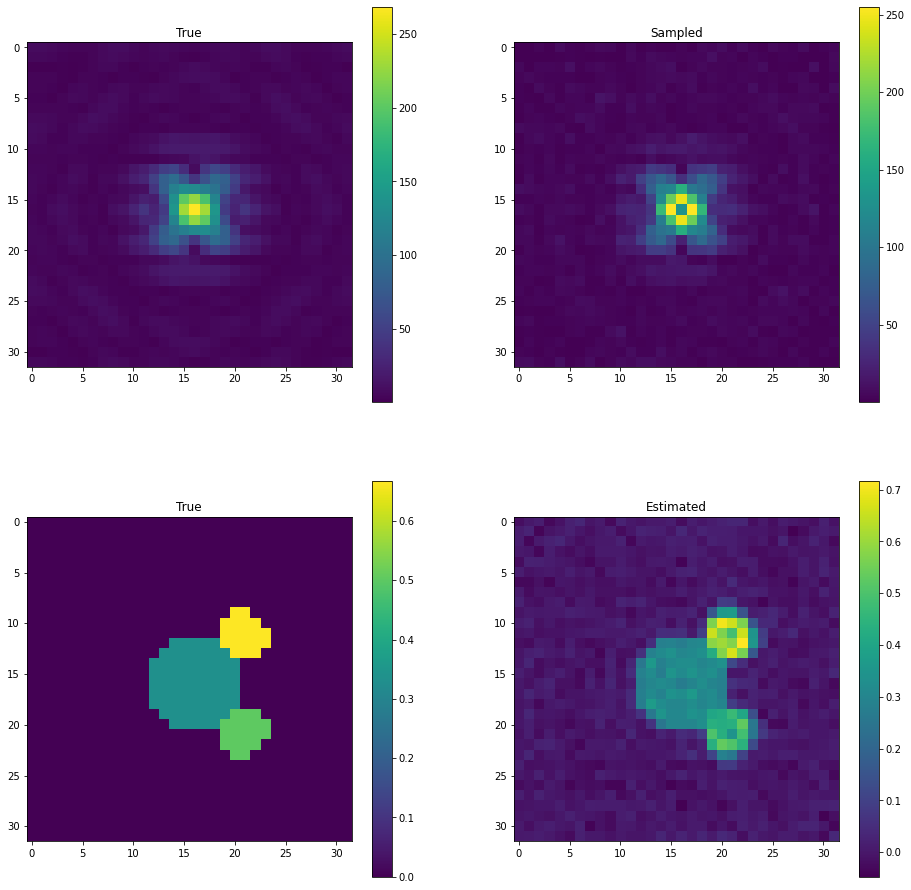

In [76]:
plot_true_vs_estimated(vol_fourier, v_hmc_mean)

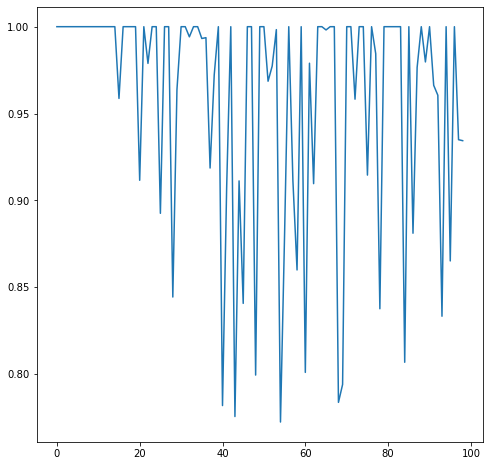

In [77]:
plt.plot(r_hmc)

In [80]:
print(loss_func_sum(v_hmc_mean, angles_true, shifts_true, ctf_params, imgs, 1))
#print(loss_func_sum(vcg1, angles_true, shifts_true, ctf_params, imgs, 1))

398908.8180741525


In [93]:
random.uniform(key, (2,3))

DeviceArray([[0.82041418, 0.96718639, 0.6960959 ],
             [0.9834125 , 0.17925635, 0.46719013]], dtype=float64)

### MCMC - orientations

In [198]:
alpha0 = 0

radius = 0.4
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha0)
loss_angles = lambda a : loss_func_batched(vol_fourier, a, shifts_true, ctf_params, imgs, 1)

def accept_reject(unif, a, ang0, ang1):
    return jax.lax.cond(unif < a, 
        lambda _ : ang1,
        lambda _ : ang0,
        None)

accept_reject_angles = jax.vmap(accept_reject, in_axes = (0, 0, 0,0))


def mcmc_angles_step(key, loss_angles, angles0):
    key1, key2 = random.split(key, 2)
    N = angles0.shape[0]             
    angles1 = generate_uniform_orientations_jax(key1, N)       
    r0exponent = -loss_angles(angles0)
    r1exponent = -loss_angles(angles1)
       
    r = jnp.exp(r1exponent-r0exponent)
    a = jnp.minimum(1, r)
    
    unif = random.uniform(key2, (N,))
    return accept_reject_angles(unif, a, angles0, angles1)

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
N_mc_samples = 10000
key, *keys = random.split(key, N_mc_samples + 1)

#angles0 = generate_uniform_orientations_jax(key, N)

for i in range(N_mc_samples):
    angles1 = mcmc_angles_step(keys[i], loss_angles, angles0)
    angles0 = angles1
    
    if jnp.mod(i, 50) == 0:
        print("Iter", i, ", loss = " ,l2sq(loss_angles(angles1))/(N*nx*nx*jnp.max(jnp.abs(vol_fourier))))


Iter 0 , loss =  316.8084247348017
Iter 50 , loss =  316.7626920271331
Iter 100 , loss =  316.7280722827452
Iter 150 , loss =  316.7161115096975
Iter 200 , loss =  316.66240665420486
Iter 250 , loss =  316.5924316611285
Iter 300 , loss =  316.55012397339567
Iter 350 , loss =  316.5034690608406
Iter 400 , loss =  316.48370862133424
Iter 450 , loss =  316.4517708686969
Iter 500 , loss =  316.40703365954
Iter 550 , loss =  316.3549741047055
Iter 600 , loss =  316.34357926862816
Iter 650 , loss =  316.32964574033923


[0.05352416 0.03139734 0.02924475]


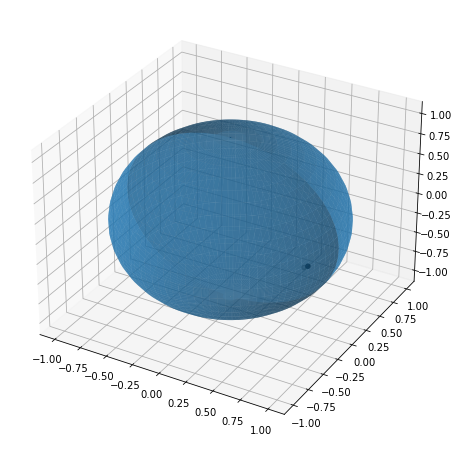

In [219]:
idx = 3
plot_angles(jnp.array([angles_true[idx], angles1[idx]]))
print(jnp.abs(angles_true[idx]-angles1[idx]))


In [220]:
s_true = slice_func_array(vol_fourier, angles_true, shifts_true, ctf_params)
s_est = slice_func_array(vol_fourier, angles1, shifts_true, ctf_params)

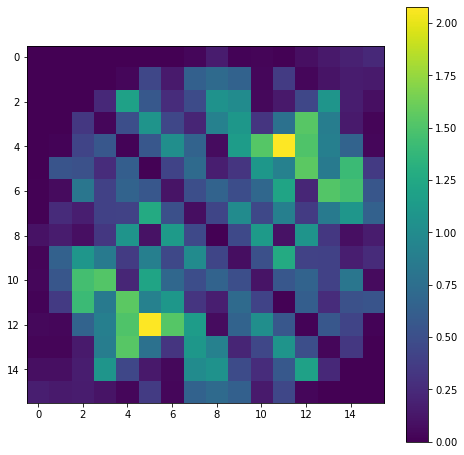

In [223]:
idx = 435
plt.imshow(jnp.fft.fftshift(jnp.abs(s_true[idx]-s_est[idx]).reshape([nx,nx]))); plt.colorbar()

#### ab initio orientations mcmc

In [ ]:
N_samples = 1000
N_iter = 30

dr = 0.05
radius = 0.3
#alpha = 0.001
alpha = 1e-10

use_sgd = True

N_cg_iter = 1000

N_sgd_iter = 310
batch_size = 500
learning_rate = 1
P = None

if use_sgd:
    N_vol_iter = N_sgd_iter
else:
    N_vol_iter = N_cg_iter

eps_vol = 1e-3

v = initialize_ab_initio_vol(project, imgs, shifts_true, ctf_params, x_grid, N_vol_iter, eps_vol, sigma_noise, use_sgd, learning_rate, batch_size)

In [67]:
nx_iter = 16
v, _ = crop_fourier_volume(v, x_grid, nx_iter)
imgs_iter, x_grid_iter = crop_fourier_images(imgs.reshape([N,32,32]), x_grid, nx_iter)
imgs_iter = imgs_iter.reshape([N, nx_iter*nx_iter])
sigma_noise_iter = jnp.ones(16*16)
mask3d = create_3d_mask(x_grid_iter, (0,0,0), 0.4)
mask2d = mask3d[0].reshape(1,-1)
v = v * mask3d
#plt.imshow(jnp.abs(jnp.fft.fftshift(v[0])))

In [71]:
slice_func_array_angles_iter, _, _, _  = get_jax_ops_iter(project, x_grid_iter, mask3d, alpha, sigma_noise_iter)



### Ab initio

In [ ]:
N_samples = 1000
N_iter = 30

dr = 0.05
radius = 0.3
#alpha = 0.001
alpha = 1e-10

use_sgd = True

N_cg_iter = 1000

N_sgd_iter = 310
batch_size = 500
learning_rate = 1
P = None

if use_sgd:
    N_vol_iter = N_sgd_iter
else:
    N_vol_iter = N_cg_iter

eps_vol = 1e-3

out_dir = '../data/'
imgs = imgs.reshape([N, nx*nx])
v_rec, angles_rec = ab_initio(project, imgs, sigma_noise, shifts_true, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius, dr, alpha, eps_vol, 'tri', True, True, True, out_dir)

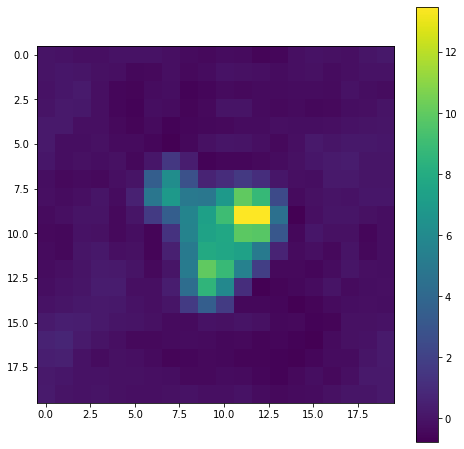

In [32]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec[0,:,:])))); plt.colorbar()

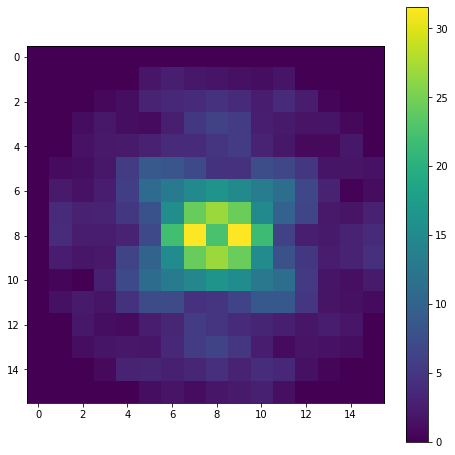

In [33]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_rec[:,:,0]))); plt.colorbar()

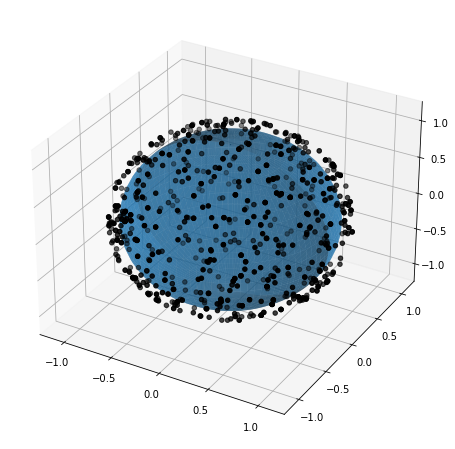

In [34]:
plot_angles(angles_rec[:1000])

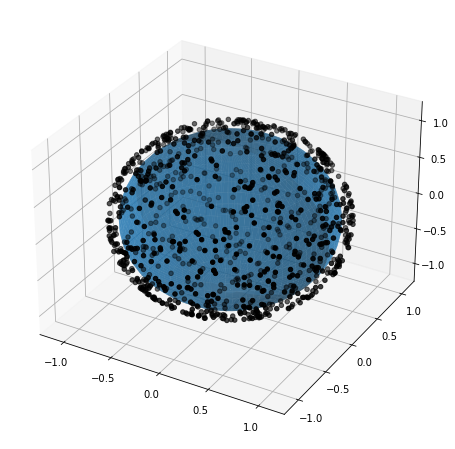

In [35]:
plot_angles(angles_true[:1000])

## Optimization with respect to volume

### CG - applied to two halves of the data

In [153]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 300

#N2 = jnp.floor(N/2).astype(jnp.int64)
N2 = 100000
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[:N2], shifts_true[:N2], ctf_params[:N2], imgs[:N2], v0.shape)

vcg1,_ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 64.31002440992265
  cg iter 50 ||r|| = 7.220554079550029e-05
  cg iter 100 ||r|| = 3.904955386825369e-05
  cg iter 150 ||r|| = 3.068800894337615e-05
  cg iter 200 ||r|| = 2.317583128990779e-05
  cg iter 250 ||r|| = 2.1132757341976225e-05


In [38]:
AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:], v0.shape)

vcg2, _ = conjugate_gradient(AA2, Ab2, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = nan
  cg iter 50 ||r|| = nan
  cg iter 100 ||r|| = nan
  cg iter 150 ||r|| = nan
  cg iter 200 ||r|| = nan
  cg iter 250 ||r|| = nan


In [39]:
#print("Final loss function = ", loss_func_sum(vcg, angles_true, shifts_true, ctf_params, imgs))
print("Relative error = ", jnp.max(jnp.abs((vcg1 - vol_fourier)/jnp.max(vol_fourier))))
print("Absolute error = ", jnp.mean(jnp.abs((vcg1 - vol_fourier))))

Relative error =  0.4732194252706147
Absolute error =  1.301268945408692


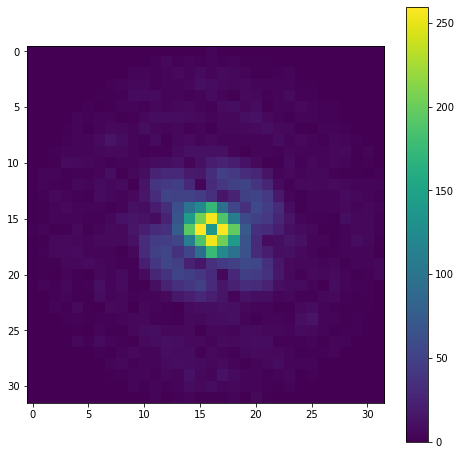

In [154]:
#mip_z(jnp.abs(jnp.fft.fftshift((vcg1)))) ; 
plt.imshow(jnp.abs(jnp.fft.fftshift((vcg1[0,:,:])))) ; 
plt.colorbar()

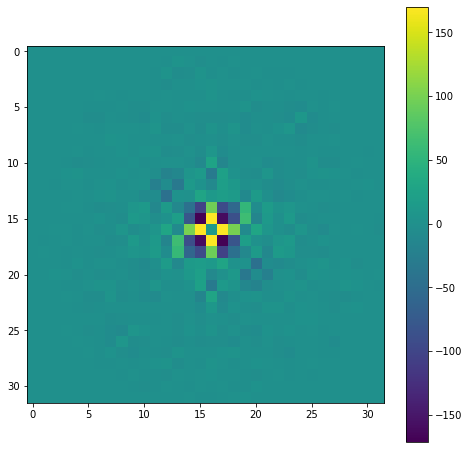

In [155]:
idx = 709

s0 = slice_func(vcg1, angles_true[idx], shifts_true[idx], ctf_params[idx])
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx,nx))); plt.colorbar()

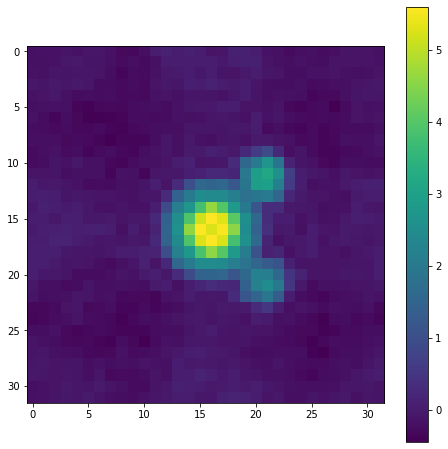

In [156]:
#mip_y(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1[:,:,0]))))
plt.colorbar()
#plt.title('Reconstruction slice')

In [160]:
loss_func_sum(vcg1)

TypeError: get_loss_funcs.<locals>.loss_func_sum() missing 5 required positional arguments: 'angles', 'shifts', 'ctf_params', 'imgs', and 'sigma'

Text(0.5, 1.0, 'Reconstruction MIP')

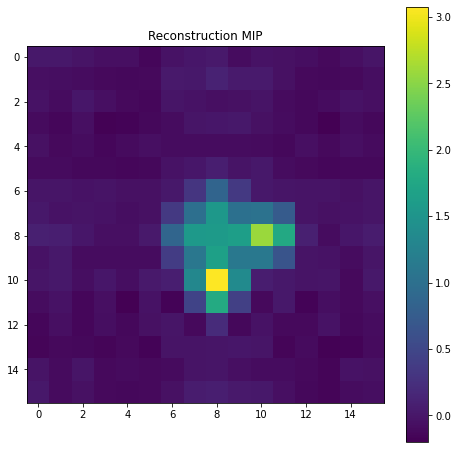

In [45]:
#mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1[0,:,:]))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

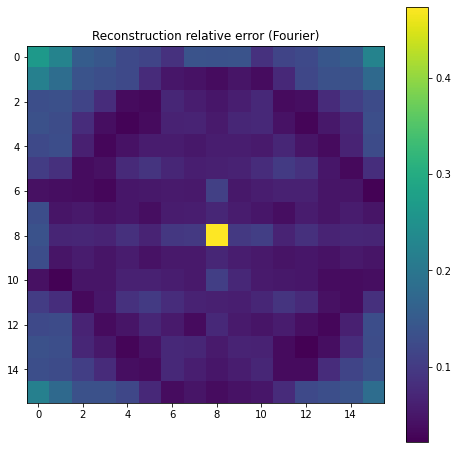

In [46]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

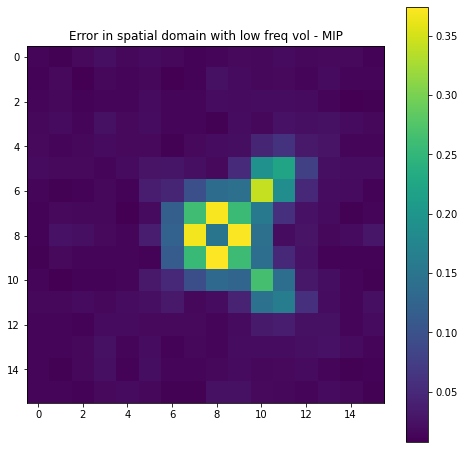

In [47]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier - vcg1)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

In [48]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1)))

with mrcfile.new('../data/simulated_rec_vol.mrc', overwrite=True) as mrc:
    mrc.set_data(vr.astype(np.float32))

### FSC

In [163]:
res, fsc, shell_points = calc_fsc(vcg1, v_hmc_max, x_grid, dr = 0.05)

In [164]:
points_v_tri = points_orientations_tri(angles_true[:int(N/2)], int(x_grid[1]))
#points_v_nn = points_orientations_nn(angles_true, x_grid[1])

Rotating coordinates
Finding point indices
Splitting in batches.
Adding up number of points from batches.


In [ ]:
#points_v_nn = points_orientations_nn(angles_true, x_grid[1])

In [166]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

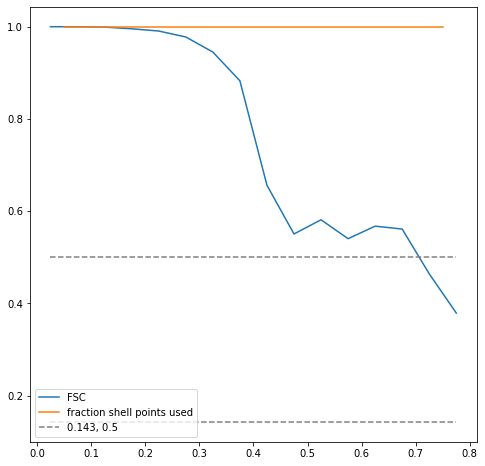

In [167]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

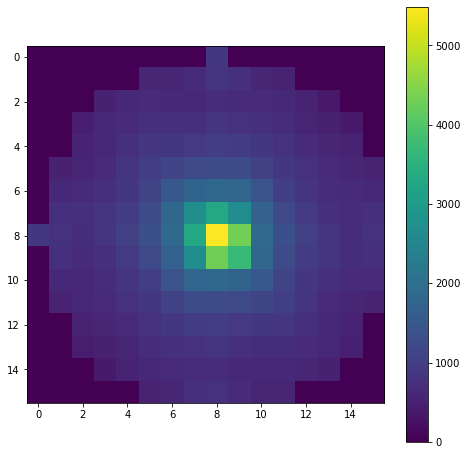

In [57]:
plt.imshow(jnp.fft.fftshift((points_v_tri[0,:,:]*mask[0,:,:]))); plt.colorbar()

In [ ]:
#res_spu, spu_nn = shell_points_used(points_v_nn, x_grid, dr = 0.05)
#plt.plot(res_spu, spu_nn)

### James

The mean is given by CG as applied above, in addition we need to calculate the variances.
The variances are given by the inverse of the gradient (AA) applied to diag(1), i.e. a volume with ones.

Looks good and agrees with counting the points above, but for whatever reason it's mirrored compared to above hmmm.

In [58]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

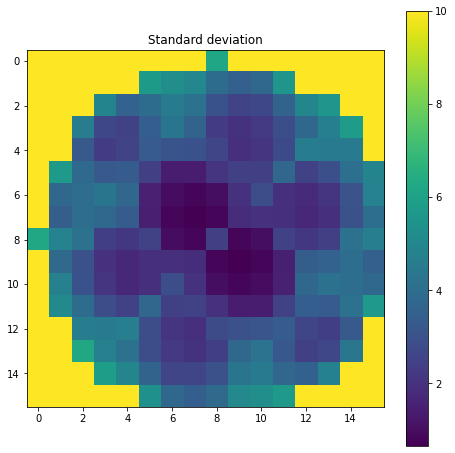

In [59]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

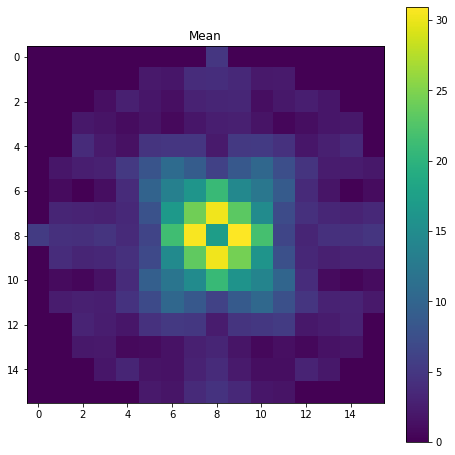

In [60]:
plt.title("Mean")
plt.imshow((jnp.abs(jnp.fft.fftshift(vcg1[:,:,0])))); plt.colorbar()

#### Train/test stuff - something's wrong here

In [ ]:
res

In [ ]:
loss = []
for radius in res[1:]:
    mask = create_3d_mask(x_grid, (0,0,0),radius)
    mask_imgs = mask[0,:,:].reshape(1,-1)
    ll = loss_func_sum(vcg1 * mask, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:]*mask_imgs)   
    loss.append(ll)
    
loss = jnp.array(loss)

#plt.imshow(jnp.fft.fftshift(mask[:,:,0]))

In [ ]:
plt.plot(res[1:], loss)

### SGD

#### A preconditioner

0.011098890110988899
1.0


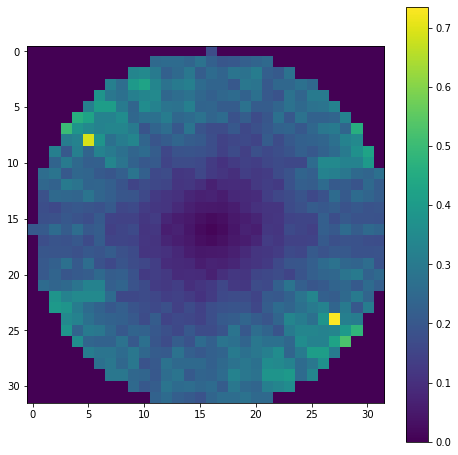

In [254]:
points_v_nn.shape
P = points_v_nn
P += 0.1
P = 1/P  * mask

P = P/jnp.max(P)

plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))

In [65]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
batch_size = N/2
N_epoch = 100
eps_gd = 1e-3
learning_rate = 1
#alpha = 100000 # <- with normalized precon

sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_batched, angles_true, shifts_true, ctf_params, imgs)
vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, None, eps_gd, True)

print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(vgd, angles_true, shifts_true, ctf_params, imgs, 1)))
print("Relative error = ", jnp.max(jnp.abs((vgd - vol_fourier)/jnp.max(vol_fourier))))

  sgd epoch 0: mean gradient = 0.042522726770200386
  sgd epoch 10: mean gradient = 0.0030659381781304672
  sgd epoch 20: mean gradient = 0.0016716639562312395
  sgd epoch 30: mean gradient = 0.0007006905204310624


TypeError: loss_func_batched() missing 1 required positional argument: 'sigma'

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

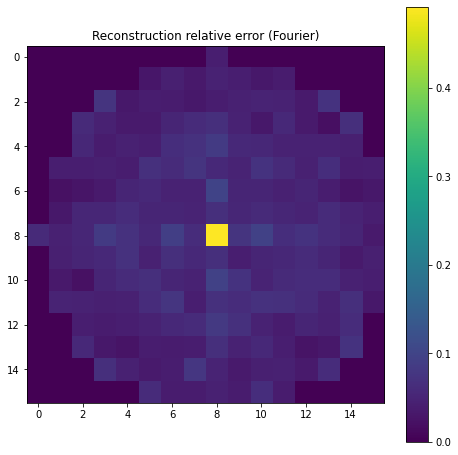

In [67]:
mip_z(jnp.abs(jnp.fft.fftshift((vgd*mask-vol_fourier*mask)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Reconstruction MIP')

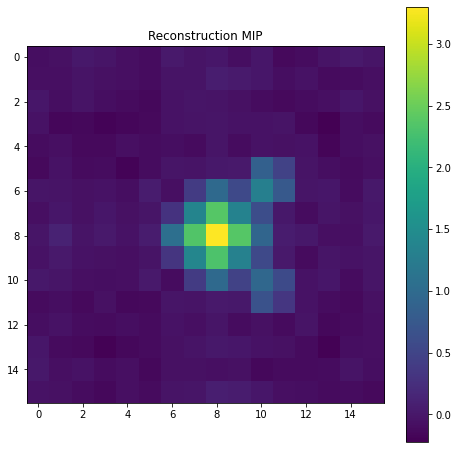

In [68]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgd[:,:,0]*mask[:,:,0]))))
plt.colorbar()
plt.title('Reconstruction MIP')

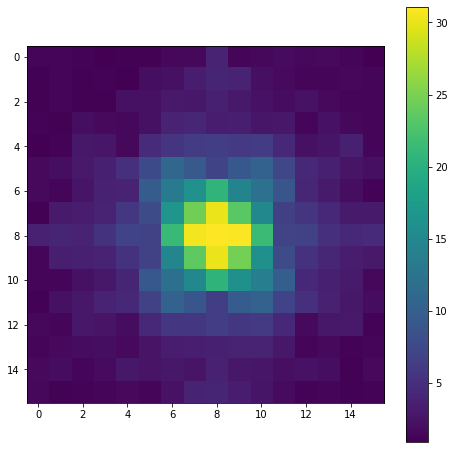

In [69]:
mip_z(jnp.abs(jnp.fft.fftshift((vgd)))) ; plt.colorbar()

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

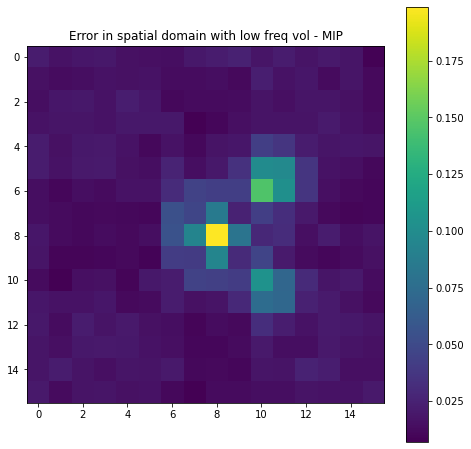

In [70]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - vgd*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

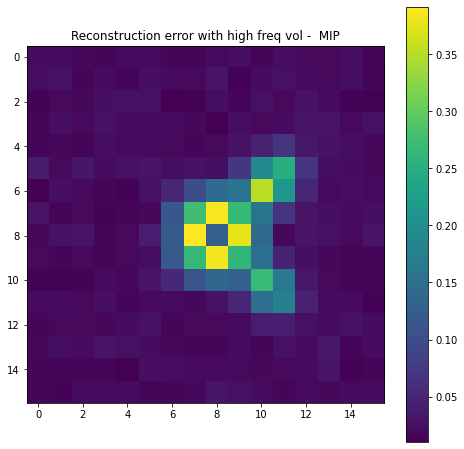

In [71]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vgd)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

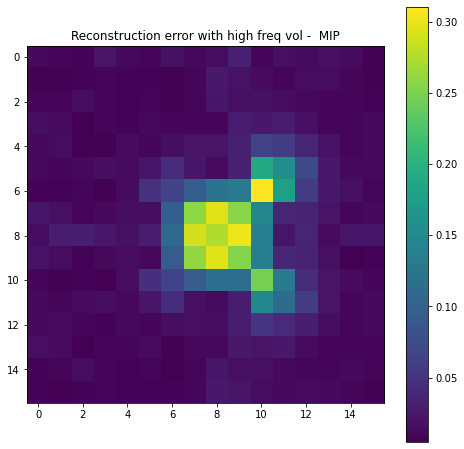

In [72]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vol_fourier*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')